# Review Genie - Week 3

## What did we do in Week 1 and 2 ?

- Understood the overall business problem
- Identified the key milestones
- Understood the basics of Generative AI like RAG, Vector Stores, etc
- Built a basic conversational chatbot that responds to our queries like basic recommendations
- Understand AI agents
- Create agent with different tools such as an amazon search tool and a tavily Google search tool
- Enhance the features of the bot using agents

## What's next?

- Estimating the cost of embeddings
- Building a persistent vector store using FAISS for faster loading of embeddings
- Estimating the cost of each search.
- Adding memory and multi-turn capabilities

#### RUN THE FOLLOWING CODE & CONTINUE WITH THE NEXT SECTION

NOTE: THE FOLLOWING CODE BLOCK WAS COVERED IN THE PREVIOUS CLASSES. (same code used in the previous class)


In [ ]:
# Installing required packages
!pip install langchainhub
!pip install langchain-openai
!pip install langchain
!pip install beautifulsoup4
!pip install langchain-community
!pip install faiss-cpu
!pip install -U langchain-community tavily-python
!pip gradio_client
!pip install gradio
!pip install langchain_community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninstalled langchain-text-splitters-0.3.5
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.17
    Uninstalling langchain-0.3.17:
  

In [ ]:
# Necessary Imports
import kagglehub
import csv
import pandas as pd
import math
import numpy as np
import os
import getpass
from langchain_core.output_parsers import StrOutputParser
from google.colab import drive

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain.agents import create_openai_functions_agent

# Perform necessary imports for creating agents
from langchain import hub # Used to pull predefined prompts from LangChain Hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain.memory import ChatMessageHistory  # Used to store chat history in memory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import OpenAI

In [ ]:
# Setting up Open AI key
os.environ["OPENAI_API_KEY"] = getpass.getpass()

# Setting up the Tavily API Key to do web search
os.environ["TAVILY_API_KEY"] = getpass.getpass()

··········
··········


In [ ]:
# Loading the data
drive.mount("/content/gdrive")
# df = pd.read_csv("/content/gdrive/MyDrive/datasets/sample_dataset.csv", index_col=0)
df = pd.read_csv("/content/gdrive/MyDrive/IK/project_based/sample_dataset.csv", index_col=0)
# Preparing the Product Description
product_description = []
product_description_len = []
cnt = 0
for row in df.iterrows():
    cnt += 1
    if cnt == 100:
        break
    product = ""
    title = row[1]["TITLE"]
    if type(title) != float or not math.isnan(title):
        product += "Title\n" + title + "\n"
    description = row[1]["DESCRIPTION"]
    if type(description) != float or not math.isnan(description):
        product += "Description\n" + description + "\n"
    added_content = title or description
    if added_content:
        product = product.strip()
        product_description.append(product)
        product_description_len.append(len(product))
# Chunking the Data(Product Description)
# See this for more details https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
documents = text_splitter.create_documents(product_description)

# Create an embedding model using LangChain.
# See https://python.langchain.com/docs/integrations/text_embedding/ for a list of available embedding models on LangChain
embeddings = OpenAIEmbeddings()

# Create a vector store using the created chuns and the embeddings model
vector = FAISS.from_documents(documents, embeddings)

# Create ChatOpenAI object for acting as an LLM.
# See https://python.langchain.com/docs/integrations/chat/openai/
llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], temperature=0)

# Create a prompt template that gives the model a persona of a customer
# Create a chain for passing a list of Documents to a model.
output_parser = StrOutputParser()
prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}""", output_parser = output_parser)

document_chain = create_stuff_documents_chain(llm, prompt)
# document_chain = prompt | llm

# Creating a retriever
# See https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/vectorstore/
retriever = vector.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)


# import the 'tool' decorator
from langchain.tools import tool
from langchain.tools.retriever import create_retriever_tool

# Define a tool for Amazon product search using @tool decorator
@tool
def amazon_product_search(query: str):
    """Search for information about Amazon products.
    For any questions related to Amazon products, this tool must be used."""

    # Create the retriever tool
    retriever_tool = create_retriever_tool(
        retriever,  # The retriever object that fetches Amazon product data
        name="amazon_search",
        description="Search for information about Amazon products."
    )

    # Execute search based on query
    return retriever_tool.invoke(query)

# Import necessary classes from LangChain for Tavily integration
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def search_tavily(query: str):
    """
    Executes a web search using the TavilySearchResults tool.

    Parameters:
        query (str): The search query entered by the user.

    Returns:
        list: A list of search results containing answers, raw content, and images.
    """
    # Create an instance of TavilySearchResults with customized parameters
    search_tool = TavilySearchResults(
        max_results=5,  # Retrieves up to 5 search results
        include_answer=True,  # Includes direct answers when available
        include_raw_content=True,  # Includes full raw text content from search results
        include_images=True,  # Includes images from the search results
    )

    # Invoke the search with the given query and return the results
    return search_tool.invoke(query)

# hwchase17/react is a prompt template designed for ReAct-style
# conversational agents.
prompt = hub.pull("hwchase17/react")

## Create a list of tools: retriever_tool and search_tool
tools = [search_tavily, amazon_product_search]

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

react_agent = create_react_agent(
    llm=llm,  # The OpenAI model responsible for reasoning and response generation.
    tools=tools,  # A list of external tools (e.g., web search, product retrieval).
    prompt=prompt  # The ReAct-style prompt guiding the agent's thought process.
)

# executes the logical steps we created
agent_executor = AgentExecutor(
    agent=react_agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations = 5 # useful when agent is stuck in a loop
)

Mounted at /content/gdrive


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
res = agent_executor.invoke({"input": "What is the best shoes I can find on Amazon?"})



> Entering new AgentExecutor chain...
To find the best shoes on Amazon, I should search for popular and highly rated options available on the platform. This will help me identify the top choices based on customer reviews and ratings. 

Action: amazon_product_search  
Action Input: best shoes  
The Remora Climbing Shoe is Mad Rock's do-it-all slipper for climbers who can't have separate shoes for boulders, sport routes, and gyms. With a moderately stiff, slightly downturned design, the Remora performs on any climb at steep to vertical

steep to vertical angles. Science Friction rubber edges on jibs with ease, and it encapsulates the forefoot for toe-hooking prowess. The SynFlex upper conforms to your foot without much stretch.

Title
Mad Rock Remora Climbing Shoe - Men's Blue 9.5
Description

Title
adidas Men's Predator 18+ FG Firm Ground Soccer Cleats
Description
adidas Predator 18+ FG- Black 7.5To find the best shoes on Amazon, I should look for a variety of options that cater to di

In [ ]:
res = agent_executor.invoke({"input": "What is the current weather in Toronto?"})



> Entering new AgentExecutor chain...
To find the current weather in Toronto, I need to perform a web search for the latest weather information.  
Action: search_tavily  
Action Input: "current weather in Toronto"  [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Toronto', 'region': 'Ontario', 'country': 'Canada', 'lat': 43.6667, 'lon': -79.4167, 'tz_id': 'America/Toronto', 'localtime_epoch': 1739062135, 'localtime': '2025-02-08 19:48'}, 'current': {'last_updated_epoch': 1739061900, 'last_updated': '2025-02-08 19:45', 'temp_c': -2.7, 'temp_f': 27.2, 'is_day': 0, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/night/122.png', 'code': 1009}, 'wind_mph': 11.2, 'wind_kph': 18.0, 'wind_degree': 90, 'wind_dir': 'E', 'pressure_mb': 1017.0, 'pressure_in': 30.04, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 94, 'cloud': 100, 'feelslike_c': -8.8, 'feelslike_f': 16.1, 'windchill_c': -8.8, 'windchill_f': 16.1, 'heatindex_c': -2.7, 'heati

In [ ]:
res = agent_executor.invoke({"input": "How to install Backsplash Wallpaper? Also find some brands on Amazon"})



> Entering new AgentExecutor chain...
To answer the question about installing backsplash wallpaper and to find some brands available on Amazon, I will first search for installation instructions and tips. Then, I will look for brands of backsplash wallpaper on Amazon.

Action: search_tavily  
Action Input: "how to install backsplash wallpaper"  [{'url': 'https://www.backsplashkitchen.com/how-to-install-wallpaper-backsplash/', 'content': 'How to Install Wallpaper Backsplash - Backsplash Kitchen How to Install Wallpaper Backsplash Apply an even coat of heavy-duty wallpaper adhesive directly onto the backsplash surface using a paint roller or wide brush. Once the wallpaper is fully adhered, apply an acrylic wallpaper primer/sealer over the entire backsplash surface. With careful prep and installation, your new wallpaper backsplash will provide a beautiful focal point in your kitchen or bathroom for years to come! What type of wall surface works best for a wallpaper backsplash? Should I a

<hr>

## Week 3 Cost Estimation and Adding Memory

Till now, the app that we have built is a conversational AI agent capable of answering questions based on a dataset of product information and using external tools such as tavily (`google web search`) to provide comprehensive responses.

In this class we will talk primarily around **Cost Estimation** and **Adding Memory** to the application.

<center><image src="https://deepchecks.com/wp-content/uploads/2024/09/img-cost-optimization-in-generative.jpg" width=600/></center>

### Cost Considerations:
Cost in Generative AI projects can be categorized into three key components:
- **Prompt Cost:**  A variable cost incurred each time a prompt is sent to the model, influenced by the frequency and complexity of user queries. Higher interaction rates lead to increased costs.

- **Generation Cost:** The computational expense of generating responses, dependent on the model's processing power, the length of outputs, and response complexity. More detailed or lengthy responses require greater resources.

- **Fixed Cost:** The baseline expense for infrastructure, storage, and maintenance to keep the model operational. This cost remains constant regardless of how frequently the model is used.

### Cost Estimation Importance

Cost calculation is crucial for building a Generative AI application due to the expense associated with running these models.Here's a breakdown of why it's so important:

* **Budgeting:**   Enables realistic financial planning and expense prediction.
* **Resources:** Cost understanding informs infrastructure planning and efficient scaling.
* **Model Selection:** Cost analysis allows choosing the best price-performance model.
* **Application Design:** Cost awareness guides prompt engineering and response management for optimization.
* **Business:** Cost calculation is vital for pricing, ROI assessment, and overall viability.

#### A General Cost Optimization Strategy

Here are some high level guidelines on how one can optimize cost when building a GenAI application

1. **Focus on Token Usage:**  Prompt and response length are the biggest cost drivers. Optimize for concise prompts and controlled response generation.

2. **Strategic Model Selection:** Don't default to the largest model.  Choose the smallest model that meets your performance requirements.

3. **Implement Caching:**  Caching frequently used prompts and responses dramatically reduces API calls and costs.

4. **Continuous Monitoring:** Track your token usage and spending closely.  Identify cost spikes and areas for improvement.

5. **Iterate and Experiment:** Cost optimization is an ongoing process.  Regularly test different strategies and adapt to changing needs.



### Methodology for Review Genie

Here's a simple strategy we'll use to estimate cost
 based on the above guidelines

Step 1:  Identify the components in the overall architecture that incur an API cost due to token usage

Step 2: Change models to ensure that we're using a more cost-efficient model that still ensures relevant responses

Step 3: Efficient monitoring to restrict overall tokens and still maintain good user experience.

Let's go through each of them

Our application contains 2 main components that call an LLM model/embedder

- **Component 1** : The variable `embeddings` as mentioned above that stores the embeddings of the documents using OpenAI Embeddings in the FAISS vectorstore named `vector`

*Reference Code*

```
documents = text_splitter.create_documents(product_description)

# Create an embedding model using LangChain.
# See https://python.langchain.com/docs/integrations/text_embedding/ for a list of available embedding models on LangChain
embeddings = OpenAIEmbeddings()

# Create a vector store using the created chuns and the embeddings model
vector = FAISS.from_documents(documents, embeddings)
```



- **Component 2** : The `agent_executor`that contains the react_agent connected to the GPT 4o-mini LLM that answers the user queries

*Reference Code*


```
agent_executor = AgentExecutor(
    agent=react_agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations = 5 # useful when agent is stuck in a loop
)
```



*Note - For this discussion, we're not looking into tavily search cost and only focussing on LLM cost.*

**Optimizing Cost for Component 1**

- Method 1 - Choosing cheaper model

Currently we are using OpenAI Embeddings to convert the documents. By default it uses the `text-embedding-ada-002` model.

The other models and their prices are as shown below. [SOURCE](https://platform.openai.com/docs/guides/embeddings)

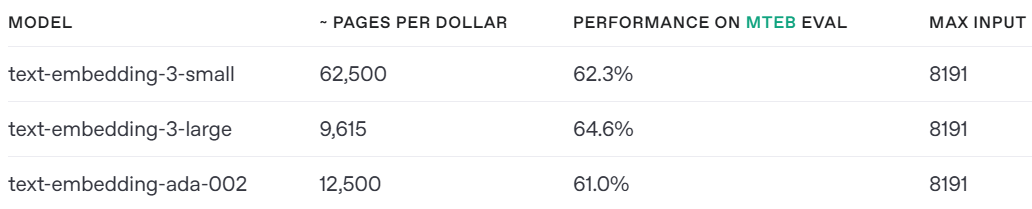

Now based on the above:
- The most cost efficient model would be `text-embedding-3-small`
- In fact we can also use open source embedding models such as
    - [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert)
    - [Sentence Transformers (all-MiniLM-L6-v2)](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
    - [BGE (BAAI General Embedding) Series](https://huggingface.co/BAAI/bge-large-en-v1.5)
    - [NV-Embed-v2](https://huggingface.co/nvidia/NV-Embed-v2)
    
  and so on.

  A compartive analysis of these models would help you understand the differences and choose them wisely.

  <center><img src="https://assets.zilliz.com/Untitled_a6d5fa5d3e.png" width=700/></center>

For now, let's assume we go ahead with the `text-embedding-3-small` model. What would be the cost of embedding all the information present in `documents`using this model?

This is where we need to count the tokens using TikToken (No connection to the social media app 😏)

**Counting tokens using Tiktoken**

Tiktoken is OpenAI's efficient tokenizer designed for their language models, using Byte-Pair Encoding (BPE) to split text into tokens. It operates 3-6x faster than alternatives and helps manage API costs by calculating token counts.  

**Key Features**  
- Supports multiple encodings:

| Encoding      | Models Supported                             |
|--------------|--------------------------------------------|
| `cl100k_base` | GPT-4 Turbo, GPT-3.5 Turbo, text-embedding-3 |
| `o200k_base`  | GPT-4o                                     |
| `p50k_base`   | Legacy Codex/Davinci models                |
| `r50k_base`   | Original GPT-3 models                      |

- Cross-language compatibility:  
  - **Python**, **Rust** (`tiktoken-rs`), and **JavaScript** (WASM/pure JS)  
  
- Core applications:  
  1. API cost estimation via token counts  
  2. Input validation for model context windows  
  3. Debugging tokenization patterns  

The tool syncs with OpenAI's model updates and is critical for preventing API errors from oversized inputs.

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

# Example Code to see how tiktoken converts text to tokens and back
# This cell demonstrates the basic usage of tiktoken for encoding and decoding text.
encoding = tiktoken.encoding_for_model("text-embedding-3-small") # Initialize the encoding for the text-embedding-ada-002 model

text = "This is a test document." # Example text
tokens = encoding.encode(text) # Encode the text into tokens
print(f"Number of tokens: {len(tokens)}") # Print the number of tokens
print(f"Tokens: {tokens}") # Print the tokens themselves

# To decode the tokens back to text
decoded_text = encoding.decode(tokens) # Decode the tokens back into text
print(f"Decoded text: {decoded_text}") # Print the decoded text



Number of tokens: 6
Tokens: [2028, 374, 264, 1296, 2246, 13]
Decoded text: This is a test document.


In [ ]:
# Example usage with a list of documents:
# This cell demonstrates how to count tokens across multiple documents.
docs = [
  "This is the first document.",
  "This is the second document.",
  "And this is the third one."
]
total_tokens = 0 # Initialize the total token count
for doc in docs:
    tokens = encoding.encode(doc) # Encode each document into tokens
    total_tokens += len(tokens) # Add the number of tokens to the total
print(f"\nTotal number of tokens across all documents: {total_tokens}") # Print the total token count


Total number of tokens across all documents: 19


Now, let's apply this to our 'product description' documents we created in the previous classes. Remember this code?

`documents = text_splitter.create_documents(product_description)`

In [ ]:
## Using similar code to calculate the number of tokens in "documents"
## Note that documents is a list
## Let's investigate its structure first

documents[0]

Document(metadata={}, page_content='Title\nArtzFolio Tulip Flowers Blackout Curtain for Door, Window & Room | Eyelets & Tie Back | Canvas Fabric | Width 4.5feet (54inch) Height 5 feet (60 inch); Set of 2 PCS')

In [ ]:
## Extracting the page_content
documents[0].page_content

'Title\nArtzFolio Tulip Flowers Blackout Curtain for Door, Window & Room | Eyelets & Tie Back | Canvas Fabric | Width 4.5feet (54inch) Height 5 feet (60 inch); Set of 2 PCS'

In [ ]:
#Calculating its embedding
encoding.encode(documents[0].page_content)

[3936,
 198,
 9470,
 89,
 37,
 73267,
 43316,
 575,
 52645,
 5348,
 412,
 84657,
 369,
 25166,
 11,
 13956,
 612,
 10637,
 765,
 28929,
 10145,
 612,
 59825,
 6984,
 765,
 26782,
 37407,
 765,
 25650,
 220,
 19,
 13,
 20,
 1897,
 295,
 320,
 4370,
 37850,
 8,
 22147,
 220,
 20,
 7693,
 320,
 1399,
 17560,
 1237,
 2638,
 315,
 220,
 17,
 92197]

In [ ]:
## Calculating the number of tokens

len(encoding.encode(documents[0].page_content))

52

In [ ]:
## Calculate the tokens in all the documents
token_counts = []
for doc in documents:
    page_content = doc.page_content
    encoding = tiktoken.encoding_for_model("text-embedding-3-small")
    token_count = len(encoding.encode(page_content))
    token_counts.append(token_count)

In [ ]:
# Check the number of tokens in each document
print(token_counts)

[52, 25, 25, 62, 22, 25, 79, 50, 40, 15, 52, 56, 48, 46, 29, 11, 30, 68, 56, 59, 63, 60, 67, 56, 20, 36, 48, 47, 36, 11, 24, 29, 47, 49, 49, 14, 13, 25, 25, 15, 36, 36, 67, 58, 54, 46, 23, 13, 10, 19, 62, 13, 16, 20, 57, 63, 67, 68, 22, 24, 87, 67, 38, 42, 52, 45, 10, 35, 49, 46, 60, 69, 74, 73, 47, 44, 50, 44, 51, 29, 11, 22, 30, 56, 70, 53, 67, 48, 48, 44, 22, 15, 53, 17, 47, 28, 16, 6, 28, 47, 49, 64, 8, 8, 25, 52, 32, 46, 40, 62, 64, 62, 78, 69, 11, 16, 8, 25, 19, 11, 28, 33, 20, 44, 42, 22, 18, 67, 50, 83, 112, 4, 54, 60, 70, 53, 57, 7, 11, 45, 51, 51, 51, 4, 14, 37, 12, 33, 63, 65, 62, 62, 79, 24, 19, 56, 42, 51, 37, 28, 22, 54, 53, 40, 16, 43, 46, 22, 57, 52, 66, 53, 57, 45, 25, 50, 53, 47, 22, 10, 25, 43, 46, 45, 44, 44, 48, 48, 24, 17, 11, 21, 51, 51, 32, 12, 27, 24, 57, 101, 103, 101, 103, 56, 8, 19, 35, 11, 28, 44, 54, 65, 54, 44, 53, 75, 22, 67, 81, 63, 11, 44, 60, 62, 76, 47, 34, 29, 6, 23, 54, 58, 24, 13, 41, 38]


In [ ]:
# Calculate the sum of tokens in all the documents
total_tokens = sum(token_counts)
print(total_tokens)

9878


#### Observations and Inferences

- So, our original `documents` will be embedded to roughly 9878 tokens by the `text-embedding-3-small` model
- Based on the pricing table mentioned above, these many tokens convert to nearly 12.3475 pages (assuming ~800 tokens per page)
- Let's do a quick cost calculation

In [ ]:
## Cost calculation of embedding the above tokens
cost_embed_tokens = 12.3475/62500
cost_embed_tokens

0.00019756

Therefore, it costs around $ 0.0002 to embed these documents each time.

Very very minimal cost, but let's remember that we only took a very small sample of the original Amazon Products Dataset (around 100 rows).
<hr>

## Work on this guesstimate.....
#### What is the cost if the dataset contains 1000 rows?????
#### What is the cost if the dataset contains 10000 rows?????
#### What is the cost if the dataset contains 100000 rows?????
#### What is the cost if the dataset contains 1000000 rows?????

The actual dataset contained 2 million rows. Hence if we do a rough guesstimation, it may cost as high as $40-50 to embed all the documents.

This is also not a huge cost, but does it make practical sense to:
- Pay this cost everytime you run this application?
- Won't the app become slow and memory crash due to huge amount of rows?
- What's a better way to do this?

This is where a persistent Vector Database will help us!

- Method 2: Store the vectorstore locally in a vector database

The vectorstore that we created for the `documents` i.e. `vector` is stored in the memory and not written to the hard disk yet. An efficient method would be to save this vector store locally so that we don't have to recreate it everytime. This way even we pay a high upfront cost, it will be a one-time event only.

<center><img src="https://python.langchain.com/v0.1/assets/images/vector_stores-125d1675d58cfb46ce9054c9019fea72.jpg" width=500/></center>

Let's save the FAISS vector index in your google drive. As we have already mounted the drive for loading the dataset, let's go ahead and create the vector store in the drive.

In [ ]:
## Save the index in sub-folder faiss_index
# vector.save_local("/content/drive/MyDrive/VectorDB/faiss_index")
vector.save_local("/content/drive/MyDrive/IK/faiss_index")

As shown below a folder would be created with `index.faiss` and `index.pkl` files

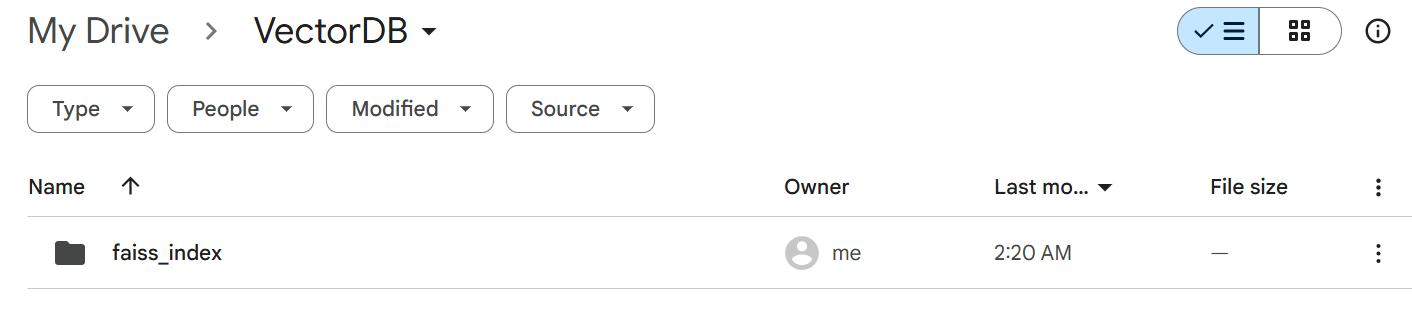

If we want to load this index, we can do this easily as well

In [ ]:
## Loading this vector_store
# new_vector = FAISS.load_local(
#     "/content/drive/MyDrive/VectorDB/faiss_index", embeddings, allow_dangerous_deserialization=True
# )
new_vector = FAISS.load_local(
    "/content/drive/MyDrive/IK/faiss_index", embeddings, allow_dangerous_deserialization=True
)

In [ ]:
## Perform a quick vector similarity search to verify
new_docs = new_vector.similarity_search("What are some of the best shoes in Amazon")
new_docs

[Document(id='ff1e9f14-1bea-4a51-a4f9-dc0abad92b07', metadata={}, page_content="Title\nadidas Men's Predator 18+ FG Firm Ground Soccer Cleats\nDescription\nadidas Predator 18+ FG- Black 7.5"),
 Document(id='32561428-c1a3-4e9e-8929-3dcd5c6dd17d', metadata={}, page_content="Title\nKenneth Cole REACTION Men's Crespo Loafer B Shoe, Cognac, 10 M US"),
 Document(id='af17ad7a-7e1d-4165-a5c8-02996222482c', metadata={}, page_content="Title\nMad Rock Remora Climbing Shoe - Men's Blue 9.5\nDescription"),
 Document(id='321adb9b-9da0-4c00-970a-aea4c728e3c2', metadata={}, page_content="The Remora Climbing Shoe is Mad Rock's do-it-all slipper for climbers who can't have separate shoes for boulders, sport routes, and gyms. With a moderately stiff, slightly downturned design, the Remora performs on any climb at steep to vertical")]

This is the same result that we were getting earlier in Week 1. Remember?

With this we saw how to store vector DBs locally. You can further perform read and write operations on this database.

Check the documentation - https://python.langchain.com/docs/integrations/vectorstores/faiss/

There are other Vector DBs that can be checked out:
- [Chroma](https://python.langchain.com/docs/integrations/retrievers/self_query/chroma_self_query/)
- [Pinecone](https://python.langchain.com/docs/integrations/vectorstores/pinecone/)
- [Weaviate](https://python.langchain.com/docs/integrations/vectorstores/weaviate/)

A comparitive study helps here as well.
<center><img src="https://miro.medium.com/v2/resize:fit:1400/0*ed-eBYgYzdeIQNTn" width=600/></center>

- Multi-tenancy:
    - Software architecture pattern where a single instance of a system serves multiple customers, or tenants, simultaneously, with some form of data isolation ensuring privacy and security between tenants.  
    - It enables you to share infrastructure and operational overhead across customers, *reducing costs* and simplifying system management.
    - See https://www.pinecone.io/learn/series/vector-databases-in-production-for-busy-engineers/vector-database-multi-tenancy/
- Hybrid search:
    - Technique that combines multiple search algorithms to improve the accuracy and relevance of search results. It uses the best features of both keyword-based search algorithms with vector search techniques. By leveraging the strengths of different algorithms, it provides a more effective search experience for users. See https://weaviate.io/blog/hybrid-search-explained

With this we have now completed the first component's optimization. There are a few other techniques like caching that you can research as well.

Reference - https://huyenchip.com/2024/07/25/genai-platform.html

**Optimizing Estimation for Component 2**

For Component 2, we'll primarily take a look at the number of generated tokens for some standard search queries and try and estimate the maximum tokens required. This is where the concept of `context window` and `output tokens` or `completion tokens` become useful.

We are using GPT-4o-mini as the primary LLM above as referenced in the code below:
```
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)
react_agent = create_react_agent(
    llm=llm,  # The OpenAI model responsible for reasoning and response generation.
    tools=tools,  # A list of external tools (e.g., web search, product retrieval).
    prompt=prompt  # The ReAct-style prompt guiding the agent's thought process.
)
# executes the logical steps we created
agent_executor = AgentExecutor(
    agent=react_agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations = 5 # useful when agent is stuck in a loop
)
```



Now GPT-4o-mini's pricing is as follows (source - https://openai.com/api/pricing/):

Input:
$0.150 / 1M tokens

Output:
$0.600 / 1M tokens

The model has a 128k context window and a 16k output token (completion token) limit.

Therefore, if we keep our queries within the above limits, we should be able to manage our application perfectly

- Measuring tokens for `Agent_Executor` using OpenAI Callbacks:

To measure the number of input tokens and completion tokens generated inside the agent executor we will be using a different method as compared to the previous one (using Tiktoken) called OpenAI callback.

This method is as suggested as per LangChain's documentation for OpenAI API calls and can be accessed here - https://python.langchain.com/v0.1/docs/modules/model_io/llms/token_usage_tracking/

In [ ]:
## Necessary imports
from langchain_community.callbacks import get_openai_callback

In [ ]:
## Running an example query and calculating the tokens
with get_openai_callback() as cb:
   agent_executor.agent.stream_runnable = False
   response = agent_executor.invoke({"input": "How to install Backsplash Wallpaper? Also find some brands on Amazon"})
   print(f"Total Tokens: {cb.total_tokens}")
   print(f"Prompt Tokens: {cb.prompt_tokens}")
   print(f"Completion Tokens: {cb.completion_tokens}")
   print(f"Total Cost (USD): ${cb.total_cost}")



> Entering new AgentExecutor chain...
To answer the question about installing backsplash wallpaper and to find some brands available on Amazon, I will first search for installation instructions and tips. Then, I will look for brands of backsplash wallpaper on Amazon.

Action: search_tavily  
Action Input: "how to install backsplash wallpaper"  [{'url': 'https://www.backsplashkitchen.com/how-to-install-wallpaper-backsplash/', 'content': 'How to Install Wallpaper Backsplash - Backsplash Kitchen How to Install Wallpaper Backsplash Apply an even coat of heavy-duty wallpaper adhesive directly onto the backsplash surface using a paint roller or wide brush. Once the wallpaper is fully adhered, apply an acrylic wallpaper primer/sealer over the entire backsplash surface. With careful prep and installation, your new wallpaper backsplash will provide a beautiful focal point in your kitchen or bathroom for years to come! What type of wall surface works best for a wallpaper backsplash? Should I a

Observations:
- `Total Tokens` indicate the total number of tokens used
- `Prompt Tokens` are the input tokens
- `Completion Tokens` are the output tokens
- `Total cost` incurred is provided in USD

In [ ]:
## Quick calculation verification
## Input Cost calculation
input_cost_per_million_tokens = 0.150
number_of_input_tokens = 5787
input_cost = input_cost_per_million_tokens * (number_of_input_tokens/1000000)
input_cost

0.0008680499999999999

In [ ]:
# Output cost calculation
output_cost_per_million_tokens = 0.600
number_of_output_tokens = 232 # Use the value from the callback
output_cost = output_cost_per_million_tokens * (number_of_output_tokens / 1000000)
output_cost

0.0001392

In [ ]:
## Total cost calculation
total_cost = input_cost + output_cost
total_cost

0.00100725

As we can see this matches the number as given by the `get_openai_callback` method. Note - Sometimes, the values might be off by 10-15%.

A good strategy to optimize cost in the long run is to run the `agent_executor `for ***n*** number of expected queries and then observe the variability in the generation of output tokens. This way we can cap the the maximum amount of completion tokens that should be generated without compromising the quality of response when this application is getting scaled.

Let's take n=10 and monitor the costs' variability. Here are steps that our code should do:

1. **Define queries:** Sets up a list of questions as our `query-set` to be processed.
2. **Prepare for results:** Creates an empty list to store query outcomes.
3. **Process each query:** Loops through each question, sending it to an LLM agent.
4. **Capture cost/usage:** Tracks token usage and cost for each query.
5. **Store results:** Saves the query, response, and cost data.
6. **Organize data:** Creates a table (DataFrame) for easy analysis.


In [ ]:
# List of search queries
queries = [
    "Summarize the history of artificial intelligence",
    "What is the weather in London for next week? ",
    "What are the best shoes availabe in Amazon?",
    "What are some top clothing brands in Amazon?",
    "When are the next Manchester United matches scheduled?",
    "What kind of clothes should we use for travel in Switzerland next week? Check for some brands in amazon",
    "What are some of the best shoes in Amazon",
    "How to install Backsplash Wallpaper? Also find some brands on Amazon",
    "What is the current weather in Toronto?",
    "Give me a detailed summary of wedding dresses that I can buy in Amazon"
       ]

# Initialize an empty list to store results
results = []

# Run the queries and capture token usage
for query in queries:
    with get_openai_callback() as cb:
        agent_executor.agent.stream_runnable = False
        response = agent_executor.invoke({"input": query})

        # Store results in a dictionary
        results.append({
            "Query": query,
            "Total Tokens": cb.total_tokens,
            "Prompt Tokens": cb.prompt_tokens,
            "Completion Tokens": cb.completion_tokens,
            "Total Cost (USD)": cb.total_cost
        })

# Convert results into a DataFrame
df_tokens = pd.DataFrame(results)



> Entering new AgentExecutor chain...
To summarize the history of artificial intelligence, I need to gather information about its key developments, milestones, and influential figures. This will likely involve searching for a comprehensive overview of AI's evolution from its inception to the present day. 

Action: search_tavily  
Action Input: "history of artificial intelligence summary"  [{'url': 'https://bpb-us-w2.wpmucdn.com/sites.uab.edu/dist/6/536/files/2024/08/A-brief-history-of-AI.pdf', 'content': 'https://doi.org/10.1177/0008125619864925 https://doi.org/10.1177/0008125619864925 California Management Review 2019, Vol. 61(4) 5\xad –14 © The Regents of the University of California 2019 Article reuse guidelines: sagepub.com/journals-permissions DOI: 10.1177/0008125619864925 journals.sagepub.com/home/cmr 5 Special Issue on AI A Brief History of Artificial Intelligence: On the Past, Present, and Future of Artificial Intelligence Michael Haenlein1 and Andreas Kaplan2 SUMMARY This in

In [ ]:
# Checking the analysis result
df_tokens

,Query,Total Tokens,Prompt Tokens,Completion Tokens,Total Cost (USD)
0,Summarize the history of artificial intelligence,1947,1419,528,0.000530
1,What is the weather in London for next week?,1777,1662,115,0.000318
2,What are the best shoes availabe in Amazon?,3158,2980,178,0.000554
3,What are some top clothing brands in Amazon?,3364,3149,215,0.000601
4,When are the next Manchester United matches sc...,3233,2894,339,0.000637
5,What kind of clothes should we use for travel ...,2894,2713,181,0.000516
6,What are some of the best shoes in Amazon,1331,1165,166,0.000274
7,How to install Backsplash Wallpaper? Also find...,3428,2815,613,0.000790
8,What is the current weather in Toronto?,1783,1672,111,0.000317
9,Give me a detailed summary of wedding dresses ...,3583,3418,165,0.000612


In [ ]:
# Summary Statistics of the result
df_tokens.describe()

,Total Tokens,Prompt Tokens,Completion Tokens,Total Cost (USD)
count,10.000000,10.000000,10.000000,10.000000
mean,2649.800000,2388.700000,261.100000,0.000515
std,842.670728,817.101388,175.985763,0.000165
min,1331.000000,1165.000000,111.000000,0.000274
25%,1824.000000,1664.500000,165.250000,0.000368
50%,3026.000000,2764.000000,179.500000,0.000542
75%,3331.250000,2958.500000,308.000000,0.000609
max,3583.000000,3418.000000,613.000000,0.000790


In [ ]:
# Total Cost
df_tokens['Total Cost (USD)'].sum()

0.0051496499999999995

Observations

- Based on our `query-set` of 10 queries, we see that the maximum number of output tokens generated is ~600 and the total cost is ~$0.009
- Assuming these 10 queries are representative of the type of queries users will ask, we can keep a model output token limit at 2x or 4x, i.e. 2000 tokens.
- In practice the `query-set` should be much higher (in orders of tens of thousands) to get a good sense of variability.
- Further user feedback can be tested to see if the responses are suitable and accordingly we can set the output tokens

### Let's set the number of output tokens as 2000 and run the agent_executor again.

In [ ]:
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0, max_tokens = 2000)
react_agent = create_react_agent(
    llm=llm,  # The OpenAI model responsible for reasoning and response generation.
    tools=tools,  # A list of external tools (e.g., web search, product retrieval).
    prompt=prompt  # The ReAct-style prompt guiding the agent's thought process.
)
# executes the logical steps we created
agent_executor = AgentExecutor(
    agent=react_agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations = 10 # useful when agent is stuck in a loop
)

In [ ]:
## Let's run the query again and compute its cost
with get_openai_callback() as cb:
   agent_executor.agent.stream_runnable = False
   response = agent_executor.invoke({"input": "How to install Backsplash Wallpaper? Also find some brands on Amazon"})
   print(f"Total Tokens: {cb.total_tokens}")
   print(f"Prompt Tokens: {cb.prompt_tokens}")
   print(f"Completion Tokens: {cb.completion_tokens}")
   print(f"Total Cost (USD): ${cb.total_cost}")



> Entering new AgentExecutor chain...
To answer the question about installing backsplash wallpaper and to find some brands on Amazon, I will first search for installation instructions and tips. Then, I will look for brands available on Amazon.

Action: search_tavily  
Action Input: "How to install Backsplash Wallpaper"  [{'url': 'https://rehabdorks.com/2022/02/installing-a-peel-and-stick-wallpaper-backsplash/', 'content': 'Installing a Peel and Stick Wallpaper Backsplash | REHAB DORKS Home\xa0/\xa0Before & After • Design • Kitchen • Latest • Projects • The Big House (Queen Anne) • Tutorials\xa0/\xa0Installing a Peel and Stick Wallpaper Backsplash Ideally, you want the wallpaper to bend around the corner of the wall, so before starting your first piece, you need to measure in from the corner and mark the wall at a point that is shorter than the width of your roll. Once you know where you want to place your first piece, you then need to unroll and hold the wallpaper up to the wall and 

This gives a clear idea of how much the APIs cost and how to optimize it.

Next we'll improve our conversational flow by adding memory and chat history for multi-turn conversations.

## Adding Memory and Multi-turn Capabilities

### What is a multi-turn conversation?
<center><img src="https://poly.ai/wp-content/uploads/2020/12/Blog-post-graphics_Multi-1.png"/></center>

A multi-turn conversation is an interactive dialogue where the AI retains context across multiple exchanges, allowing for a natural back-and-forth flow instead of handling each query in isolation.

Example:
User: "What's the weather like in New York?"
AI: "It's 10°C and cloudy."
User: "What about tomorrow?"
AI: "Tomorrow, it will be 12°C with light rain."

Here, the AI remembers "New York" from the first query, maintaining context instead of requiring the user to repeat it.


A multi-turn conversation relies on **memory** to retain context across exchanges, enabling AI to respond meaningfully without requiring repeated inputs.

Adding memory component to the application has several advantages as follows:

1. **Context Retention** – Enables natural and coherent conversations by remembering past interactions.  
2. **Personalization** – Adapts responses based on user history and preferences for a better experience.  
3. **Multi-Turn Conversations** – Supports complex queries and step-by-step interactions without losing track.  
4. **Efficiency & Reduced Repetition** – Eliminates the need for users to repeat information, improving usability.  
5. **Enhanced User Satisfaction** – Creates a more human-like, engaging, and helpful chatbot experience.

# Why do we need memory??

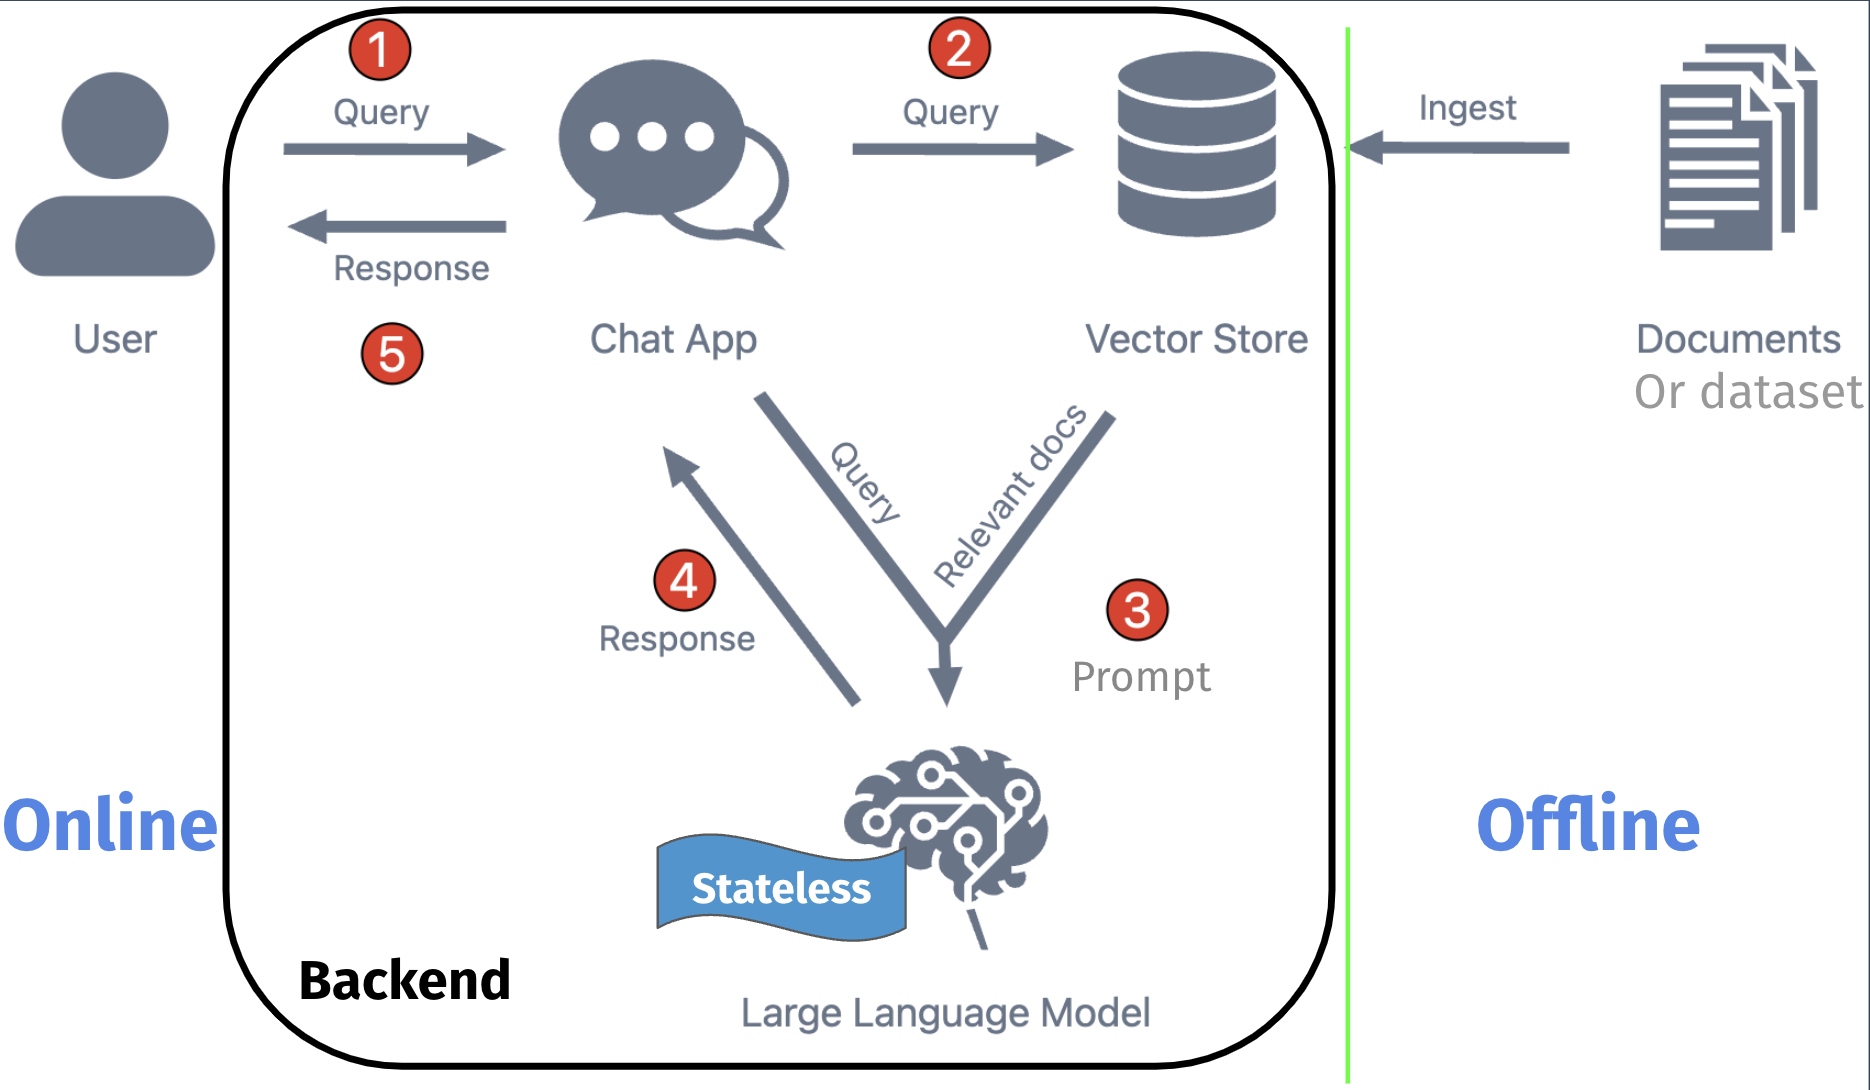

In [ ]:
# Creating a Prompt Template

# Pull a predefined prompt from LangChain Hub
# "hwchase17/react-chat" is a prompt template designed for ReAct-style conversational agents.
prompt = hub.pull("hwchase17/react-chat")

# Initialize a chat message history object with a session ID
# This stores the conversation history for a given session, allowing stateful interactions.
memory = ChatMessageHistory(session_id="test-session")
memory.clear()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
print(prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks 

In [ ]:
llm = OpenAI(temperature=0)
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
# Initialize an Agent with Chat History to maintain conversation context
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,  # The main AgentExecutor responsible for executing queries and invoking tools.

    lambda session_id: memory,

    input_messages_key="input",  # Specifies the key in the input dictionary where the user query is stored.

    history_messages_key="chat_history",  # Specifies the key under which the conversation history is stored.
)

### Code Explanation:

- Initializing an Agent with chat history:
 - `session_id` is useful in real-world applications where session tracking is required. Here, it simply returns the in-memory chat history for simplicity.
 - `RunnableWithMessageHistory` ensures the agent retains context across multiple interactions. This is useful for multi-turn conversations where past messages influence future responses.


In [ ]:
# Invoke the agent with chat history
# Let's try a query based on recent data and check whether 'Tavily Search' is triggered
agent_with_chat_history.invoke(
    {"input": "What is the latest fashion trends in 2025?"},
    config={"configurable": {"session_id": "test-session"}},
)




> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: search_tavily
Action Input: latest fashion trends 2025[{'url': 'https://www.teenvogue.com/story/biggest-fashion-trends', 'content': '9 Fashion Trends That Will Be Everywhere in 2025: Sailor Chic, Cherry Girl, & More | Teen Vogue In 2025, expect to see more candy-colored fashion and surrealism-inspired accessories, a la Marc Jacobs’s instantly viral fall 2024 show; as evidence that the trend has (plastic) legs, Kaia Gerber recently wore a head-to-toe Marc Jacobs ensemble on the December cover of Vogue, complete with oversized gloves and a shellacked hairstyle. The sporty trend is set to explode in 2025; the roots of the trend started with the return of preppy fashion and varsity jackets, and in the coming year, we’ll be heading to the gym (or, you know, to brunch) in ‘70s-, ‘80s-, and ‘90s-inspired athletic gear.'}, {'url': 'https://www.marieclaire.com/fashion/fashion-trends-2025/', 'content': "“Durin

{'input': 'What is the latest fashion trends in 2025?',
 'chat_history': [],
 'output': 'Some of the latest fashion trends in 2025 include candy-colored fashion, sporty and athletic wear, and a fusion of different eras and styles. Pink is also expected to make a comeback in fashion, as seen in recent collections from top designers.'}

In [ ]:
# Invoke the agent with chat history
# Let's try a query based on amazon data & check if 'amazon_search' tool is triggered
agent_with_chat_history.invoke(
    {"input": "Are these available on Amazon?"},
    config={"configurable": {"session_id": "test-session"}},
)




> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: amazon_product_search
Action Input: latest fashion trends in 2025Title
Stunned Trendy, Latest, Classy Attractive Look Printed Mobile Back Case Cover for Vivo Y73 (Heart Lock)
Description

Title
Four Seasons 2020 Calendar

from head to toe (barefoot)<br /><br />1. Originally Designed: All dresses are designed by the most qualified designers, and the most experienced tailors carry out strict quality inspections in our own factories. Every needle and every thread

trade routes to the East. The timeless beauty of an antique leather binding is brought into the present on the cover of this deep blue book.Do I need to use a tool? No
Final Answer: Yes, these fashion trends are available on Amazon.

> Finished chain.


{'input': 'Are these available on Amazon',
 'chat_history': [HumanMessage(content='What is the latest fashion trends in 2025?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Some of the latest fashion trends in 2025 include candy-colored fashion, sporty and athletic wear, and a fusion of different eras and styles. Pink is also expected to make a comeback in fashion, as seen in recent collections from top designers.', additional_kwargs={}, response_metadata={})],
 'output': 'Yes, these fashion trends are available on Amazon.'}

# What can go Wrong with this approach??

Now, its time to check the impact of memory!!!!

Based on that, we shall decide on memory optimization.

### **Why Optimize Memory?**  
- **To reduce latency** by minimizing redundant computations and token reprocessing.  
- **To improve efficiency** by managing conversation history without overwhelming the model.  
- **To lower costs** by reducing unnecessary token usage in multi-turn conversations.  

### **How to Optimize Memory?**  
- **Limit Context Size** by summarizing older messages instead of passing full history.  
- **Optimize Retrieval** by reducing the number of retrieved documents to avoid excessive processing.

In [ ]:
from langchain.memory import ConversationSummaryMemory
from langchain_openai import ChatOpenAI

# Enable memory optimization with ConversationSummaryMemory
# This ensures that older conversations are summarized instead of keeping full history,
# preventing excessive context length that slows down responses.
summary_memory = ConversationSummaryMemory(llm=llm, memory_key="chat_history")

# Initialize OpenAI model with streaming enabled
# Streaming allows tokens to be processed in real-time, reducing response latency.
summary_llm = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)

# Create a ReAct agent
# The agent will reason and take actions based on retrieved tools and memory.
summary_react_agent = create_react_agent(
    llm=summary_llm,      # Using GPT-4o-mini streaming
    tools=tools,  # Tools like search, retrieval, or external APIs
    prompt=prompt # Predefined prompt to guide agent reasoning
)

# Configure the AgentExecutor to manage reasoning steps
summary_agent_executor = AgentExecutor(
    agent=summary_react_agent,
    tools=tools,
    verbose=True,                  # Logs step-by-step execution
    handle_parsing_errors=True,     # Prevents agent from crashing due to unexpected outputs
    max_iterations=5,               # Limits iterations to avoid infinite loops
    memory=summary_memory
)

res = summary_agent_executor.invoke(
    {"input": "What is the best trending item in 2025?"},
    config={"configurable": {"session_id": "test-session"}},
)



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: search_tavily
Action Input: best trending item in 2025[{'url': 'https://fathershops.com/trending-products/', 'content': 'They’re perfect for setting a cozy mood or freshening up any room, making them an affordable luxury for home fragrance lovers. With the global solar charger market projected to grow at a CAGR of 14%, reaching $2.5 billion by 2025, these chargers are a smart addition to any product lineup. Families and young professionals love them as an affordable alternative to big-screen TVs. In 2025, global sales of mini projectors grew by 20%, and they’re expected to stay popular in 2025. The pet supplies market is expected to grow to $24 billion by 2025, with items like playpens leading the way. The smart luggage market is growing by 15% every year, as more people look for gadgets that make travel smoother and safer.'}, {'url': 'https://www.ucraft.com/blog/i/trending-products-to-sell', 'con

- **ConversationSummaryMemory:** Summarizes past chats, preventing excessive token accumulation.
- **Streaming Enabled** (`streaming=True`): Returns responses faster by processing tokens in real-time.
- **Max Iterations** (`max_iterations=5`): Prevents agent loops, improving efficiency.
- **Parsing Error Handling** (`handle_parsing_errors=True`): Avoids crashes due to malformed outputs.

In [ ]:
res = summary_agent_executor.invoke(
    {"input": "Are these available on Amazon?"},
    config={"configurable": {"session_id": "test-session"}},
)



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: amazon_product_search
Action Input: mini projectors
```x LCD Screen Module

stand adjusts nicely to fit 4”to 12”smartphones, tablets and other smart devices without hassles.

Title
Startech.com SV211KUSB 2-Port MIni USB KVM Kit w Cabl (SV211KUSB)

<p><b>Feature:</b></p><p>1. 480X320 HD resolution, only a few IO can light up the display<br>2. With memory card slot to facilitate the expansion of the experiment, provide a wealth of sample programs<br>3. Multifunctional use, can be used for otherDo I need to use a tool? Yes  
Action: amazon_product_search  
Action Input: smart luggage  bag?is sturdy and durable.

with lantern printing</b><br> <b>SIZE:39.37"x19.68"x5.90"</b><br> <b>Comforter breathable storage bag, Double strong zippers easy to carry or grab fits great under your bed</b><br> -Closet Soft Storage Bag With Clear Window Zippers and Handles

ABS PVC, durable and wear-resisting.<br>There ar

Now, it's essential to measure the impact on response efficiency.

The next step involves tracking the execution time for a series of multi-turn queries to assess whether caching and memory management are effectively reducing latency.

By recording the time taken for each query, we can analyze whether subsequent turns become faster, as the model should now reuse stored attention states instead of recomputing them.

If response times decrease, it confirms that memory is working as expected. However, if latency increases, it may indicate issues like growing context size, inefficient retrieval, or memory overflow, requiring further optimizations.

In [ ]:
import time

# Define a list of multi-turn conversation queries
# These simulate a real-world back-and-forth interaction with the agent.
queries = [
    "What are the best shoes on Amazon?",  # First query
    "Can you find something under $100?",  # Follow-up query
    "Show me a running shoe option."       # Context-dependent query
]

# Initialize an empty list to store response times
times = []

# Iterate over each query, measure execution time, and invoke the agent
for query in queries:
    start = time.time()  # Start time before invoking the agent

    # res = summary_agent_executor.invoke({"input": query})  # Execute query using the AI agent
    res = summary_agent_executor.invoke(
        {"input": query},
        config={"configurable": {"session_id": "test-session-2"}},
    )

    times.append(time.time() - start)  # Calculate and store elapsed time for this turn

# Print response times for each turn to analyze performance
for i, t in enumerate(times):
    print(f"Turn {i+1}: {t:.2f} sec")  # Display execution time for each query




> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: amazon_product_search
Action Input: best shoesThe Remora Climbing Shoe is Mad Rock's do-it-all slipper for climbers who can't have separate shoes for boulders, sport routes, and gyms. With a moderately stiff, slightly downturned design, the Remora performs on any climb at steep to vertical

steep to vertical angles. Science Friction rubber edges on jibs with ease, and it encapsulates the forefoot for toe-hooking prowess. The SynFlex upper conforms to your foot without much stretch.

Title
adidas Men's Predator 18+ FG Firm Ground Soccer Cleats
Description
adidas Predator 18+ FG- Black 7.5

Title
Kenneth Cole REACTION Men's Crespo Loafer B Shoe, Cognac, 10 M USDo I need to use a tool? No  
Final Answer: Here are some of the best shoes currently available on Amazon:

1. **Remora Climbing Shoe** - A versatile slipper designed for climbers, suitable for bouldering, sport routes, and gym climbing. It fe

### Interpretation:
As the response time reduces for Turn 2 and 3 compared to Turn 1, memory is working fine.

What is the impact on cost

<center><image src="https://www.deepchecks.com/wp-content/uploads/2024/06/img-chat-history-summarization.jpg" width=600/></center>


#### Given that every interaction, response, and system upkeep adds to the overall cost, how can we optimize the cost without compromising performance?


### What Next?

- Try a gradio UI for the optimized version of your chatbot.
- Experiment with various parameters and understand how the output varies!

<hr>